# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.6/site-packages (0.11.1)


In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DateType
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
import pyspark.sql.functions as func
from pyspark.sql.window import Window

from datetime import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

First we need to know the schema of the data, this will help us to identify the initial structure and useful columns for the objective.

In [5]:
#get data shcema
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Next we must do a basic data analysis to know more about the information, for this case we are going to divide the columns into two main groups, one categorical and the other numerical.

In [6]:
#Number of registers on the data
user_log.count()

286500

In [7]:
#Definig list of columns
categorial_col =  [i[0] for i in user_log.dtypes if i[1].startswith('string')]
numeric_col = [i[0] for i in user_log.dtypes if i[0] not in categorial_col]

In [8]:
#Iterating over the columns to make a basic analysis
for i in categorial_col:
    print("Analysis for",i)
    user_log.groupby(user_log[i]).count().orderBy(user_log[i]).show()

Analysis for artist
+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null|58392|
|                 !!!|   10|
|        & And Oceans|    1|
|'N Sync/Phil Collins|    4|
|        'Til Tuesday|    2|
| 't Hof Van Commerce|    1|
|'t Hof Van Commer...|    1|
|       (Love) Tattoo|    1|
|          (hed) p.e.|    4|
|*NSYNC featuring ...|    1|
|  + / - {Plus/Minus}|   23|
|                 +44|   37|
|          -123 minut|    1|
|            -123min.|    1|
|       ...And Oceans|    1|
|...And You Will K...|    5|
|           1 40 4 20|    2|
|1 Giant Leap feat...|    4|
|1 Giant Leap feat...|    3|
|1 Giant Leap feat...|    1|
+--------------------+-----+
only showing top 20 rows

Analysis for auth
+----------+------+
|      auth| count|
+----------+------+
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
|Logged Out|  8249|
+----------+------+

Analysis for firstName
+----------+-----+
| firstName|count|
+----------+-----+

In [9]:
#Exploration of the rows with empty userId
user_log.filter(user_log.userId == '').groupby(["auth", "page"]).count().orderBy("auth").show()

+----------+-------------------+-----+
|      auth|               page|count|
+----------+-------------------+-----+
|     Guest|           Register|   18|
|     Guest|              Error|    1|
|     Guest|Submit Registration|    5|
|     Guest|              About|   14|
|     Guest|               Help|   23|
|     Guest|               Home|   36|
|Logged Out|               Home| 4339|
|Logged Out|              About|  415|
|Logged Out|              Error|    5|
|Logged Out|              Login| 3241|
|Logged Out|               Help|  249|
+----------+-------------------+-----+



In this first analysis we can see that there are 8346 rows for page browsing events without Login, this information is not useful for our analysis so we can filter it.

In [10]:
processed_df = user_log.filter(user_log.userId != '')

In [11]:
#Iterating over the columns to make a basic analysis
for i in numeric_col:
    print("Analysis for",i)
    processed_df.describe(i).show()

Analysis for itemInSession
+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            278154|
|   mean|114.89918174824018|
| stddev|  129.851729399489|
|    min|                 0|
|    max|              1321|
+-------+------------------+

Analysis for length
+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+

Analysis for registration
+-------+--------------------+
|summary|        registration|
+-------+--------------------+
|  count|              278154|
|   mean|1.535358834084427...|
| stddev| 3.291321616327586E9|
|    min|       1521380675000|
|    max|       1543247354000|
+-------+--------------------+

Analysis for sessionId
+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|            2

In this step we remove some columns that we consider not necessary for the project such as: auth, firstName, lastName, location, method.

In [12]:
col = ["artist", "itemInSession", "page", "registration", "sessionId", "song", "status", "ts", "level", "userAgent", "userId", "length", "gender"]

Also, we need to change the format of some columns, this will help us in the feature engineering step.

In [13]:
#Change unix timestamp to date
convert_date = udf(lambda x: datetime.utcfromtimestamp(int(x/1000)).strftime('%Y-%m-%d %H:%M:%S'))
processed_df = processed_df.withColumn("registration", convert_date("registration"))
processed_df = processed_df.withColumn("ts", convert_date("ts"))

In [14]:
#Convert the agent into OS
convert_agent = udf(lambda x: x.replace('Mozilla/5.0 (','').split(';')[0].split(' ')[0].replace('"', ''))
processed_df = processed_df.withColumn("userAgent", convert_agent("userAgent"))

### Define Churn
Now that we have done our first basic analysis, we need to define the churn indicator

In [15]:
#churn_flag = udf(lambda x: 1 if x in ("Submit Downgrade", "Cancellation Confirmation") else 0)
create_flag = udf(lambda x : 1 if x=="Cancellation Confirmation" else 0)
processed_df = processed_df.select(col).withColumn("churnFlag", create_flag("page"))

In [16]:
#Preview the information after applying the churnFlag rule
processed_df.where(processed_df.userId == '30').show(5)

+--------------+-------------+---------------+-------------------+---------+--------------------+------+-------------------+-----+---------+------+---------+------+---------+
|        artist|itemInSession|           page|       registration|sessionId|                song|status|                 ts|level|userAgent|userId|   length|gender|churnFlag|
+--------------+-------------+---------------+-------------------+---------+--------------------+------+-------------------+-----+---------+------+---------+------+---------+
|Martha Tilston|           50|       NextSong|2018-09-28 22:22:42|       29|           Rockpools|   200|2018-10-01 00:01:57| paid|  Windows|    30|277.89016|     M|        0|
|  Adam Lambert|           51|       NextSong|2018-09-28 22:22:42|       29|   Time For Miracles|   200|2018-10-01 00:06:34| paid|  Windows|    30| 282.8273|     M|        0|
|     Daft Punk|           52|       NextSong|2018-09-28 22:22:42|       29|Harder Better Fas...|   200|2018-10-01 00:11:16| 

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

For our feature engineering, we first use the different navigation pages to specify some events that can help us decide if the user is going to churn:

<ul>
    <li><b>addFriend:</b> Sets whether the user adds a friend to the list, improving their affinity with the platform.</li>
    <li><b>addToPlaylist:</b> Sets whether the user adds a song to a playlist for better interaction with the platform.</li>
    <li><b>advert:</b> On some platforms the user does not like to receive constant advertising while listening to their favorite music, so this can be an interesting variable to determine abandonment.</li>
</ul>

In [17]:
#Define a function to create addFriend flag
create_flag = udf(lambda x : 1 if x == "Add Friend" else 0)
#Apply function to dataframe
processed_df = processed_df.withColumn("addFriend", create_flag("page"))

In [18]:
#define a function to create addToPlaylist flag
create_flag = udf(lambda x : 1 if x == "Add to Playlist" else 0)
#Apply function to dataframe
processed_df = processed_df.withColumn("addToPlaylist", create_flag("page"))

In [19]:
#define a function to create advert flag
create_flag = udf(lambda x : 1 if x == "Roll Advert" else 0)
#Apply function to dataframe
processed_df = processed_df.withColumn("advert", create_flag("page"))

The dates in the data frame aren't in a format that we can process, so we need to adjust them to a date and time format that we can work with, this will help us to do some interesting analysis, in this case the antique of the platform users using the registration date and the activity date.

Another important feature to extract is the one that detects the error when interacting with the platform. This can be a promising event to determine the loss of users.

In [20]:
#Define feature functions
dtfun = udf(lambda date_str, date_str2: str(datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S') -datetime.strptime(date_str2, '%Y-%m-%d %H:%M:%S')).split(' ')[0])
error = udf(lambda x: 1 if x == 404 else 0)

The next step is to create a grouping dataframe that allows us to have all the features per user, creating new measures such as:

<ul>
    <li><b>artistListened:</b> total of artists listened to by a user.</li>
    <li><b>songListened:</b> total number of songs listened to by a user.</li>
    <li><b>maxItemSession:</b> maximum number of items in all sessions of a user.</li>
    <li><b>sessions:</b> number of different sessions by a user.</li>
    <li><b>antique:</b> age of the user in the platform.</li>
    <li><b>totalSeconds:</b> total seconds of music listened to on the platform.</li>
    <li><b>songsAdded:</b> number of songs added by a user.</li>
    <li><b>friendsAdded:</b> number of friends added by a user.</li>
    <li><b>sumAdverts:</b> total number of ads a user receives.</li>
</ul>

In [21]:
#Generating the optimal query to get all the parameters
general_analyisis = processed_df.groupby(['userId']).agg(
                        func.countDistinct('artist').alias('artistListened'), 
                        func.countDistinct('song').alias('songListened'),
                        func.max('itemInSession').alias('maxItemSession'),
                        func.round(func.avg('itemInSession'),0).alias('avgItemSession'),
                        func.countDistinct('sessionId').alias('sessions'),
                        func.round(func.sum('length'),0).alias('totalSeconds'),
                        dtfun(func.max('ts'),func.max('registration')).alias('antique'),
                        func.sum(error('status')).alias('errors'),
                        func.max('gender').alias('gender'),
                        func.max('userAgent').alias('userAgent'),
                        func.max('addFriend').alias('addFriend'),
                        func.max('addToPlaylist').alias('addToPlaylist'),
                        func.max('level').alias('level'),
                        func.sum('addToPlaylist').alias('songsAdded'),
                        func.sum('addFriend').alias('friendsAdded'),
                        func.sum('advert').alias('sumAdverts'),
                        func.max('churnFlag').alias('churnFlag'))

Some of the features thought for this exercise are based on per session behavior, so we need to create a dataframe that groups parameter by userId and sessionId:

<ul>
    <li><b>avgSongListened:</b> average number of songs listened to by the user in all sessions.</li>
    <li><b>avgSessionDuration:</b> average of the duration of user interaction in all sessions.</li>
</ul>

In [22]:
#Definition of the initial dataframe that group the user information by session
sesion_init_analyisis = processed_df.groupby(['userId','sessionId']).agg( 
                        func.countDistinct('song').alias('songListened'),
                        func.round(func.sum('length'),0).alias('totalSeconds'))

In [23]:
#Defining final grouped dataframe that extract the session features
sesion_analyisis = sesion_init_analyisis.groupby(['userId']).agg( 
                        func.round(func.avg('songListened'),0).alias('avgSongListened'),
                        func.round(func.sum('totalSeconds'),0).alias('avgSessionDuration'))

Finally, we perform a left join on the data frame to join all the features into a single data frame <code>general_analyisis</code> and <code>sesion_analyisis</code>

In [24]:
#Definition of the final dataframe joining 
final_df = general_analyisis.join(sesion_analyisis, general_analyisis.userId == sesion_analyisis.userId,how='left').drop(general_analyisis.userId)

In [25]:
#Preview of the information after perform the feature engineering
final_df.show(5)

+--------------+------------+--------------+--------------+--------+------------+-------+------+------+---------+---------+-------------+-----+----------+------------+----------+---------+------+---------------+------------------+
|artistListened|songListened|maxItemSession|avgItemSession|sessions|totalSeconds|antique|errors|gender|userAgent|addFriend|addToPlaylist|level|songsAdded|friendsAdded|sumAdverts|churnFlag|userId|avgSongListened|avgSessionDuration|
+--------------+------------+--------------+--------------+--------+------------+-------+------+------+---------+---------+-------------+-----+----------+------------+----------+---------+------+---------------+------------------+
|           252|         269|           111|          36.0|       7|     66941.0|     55|   0.0|     F|   iPhone|        1|            1| free|       7.0|         4.0|      52.0|        0|100010|           39.0|           66940.0|
|           339|         378|           157|          61.0|       6|     940

In [26]:
final_df.groupBy('churnFlag').count().show()

+---------+-----+
|churnFlag|count|
+---------+-----+
|        0|  173|
|        1|   52|
+---------+-----+



### Exploration of the features

In this step, we need to evaluate how all the new parameters behave with the main feature: Chrun. To facilitate the validation of the features, we transform our Spark data frame into a pandas data frame to use all the advantages of the <code>matplotlib</code> and <code>seaborn</code> libraries.

In [27]:
#Converting spark dataframe to pandas
final_df_pandas = final_df.toPandas()

In [28]:
#Delete a row that generates conflict to transform antique column to numeric
final_df_pandas = final_df_pandas[final_df_pandas.antique!='7:31:46']

In [29]:
#Defining a list of categorical columns for independent analysis
categorial_columns = ["gender", "userAgent", "addFriend", "addToPlaylist", "level",  "churnFlag"]

In [30]:
#Basic transformation of numeric columns
for i in final_df_pandas.columns:
    if (i not in categorial_columns):
        final_df_pandas[i] = final_df_pandas[i].astype(np.float64)

In the following box we are performing a box plot analysis for the numerical variables, this is important to see if the data distribution has a different behavior in Churn users.

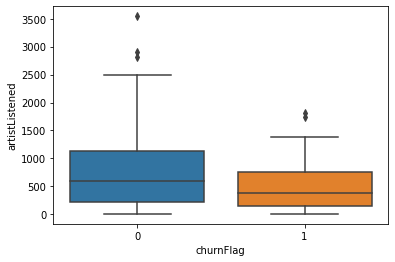

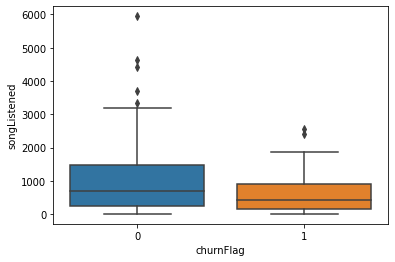

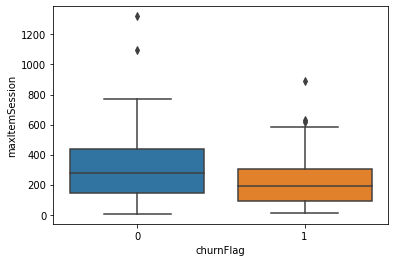

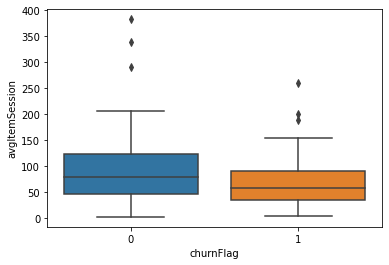

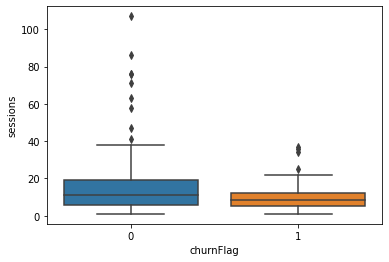

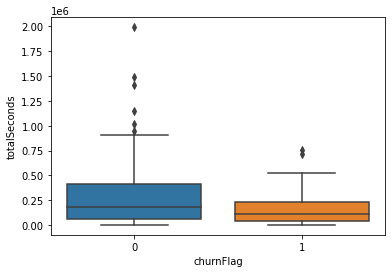

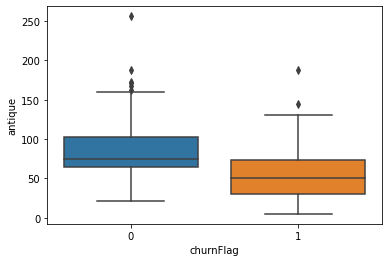

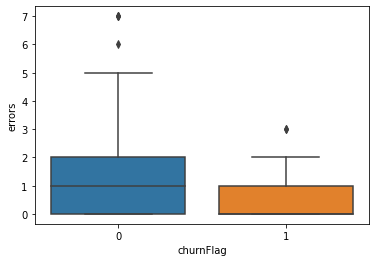

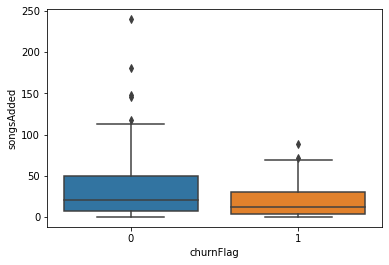

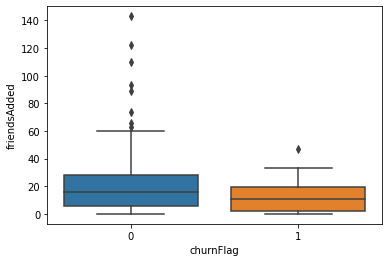

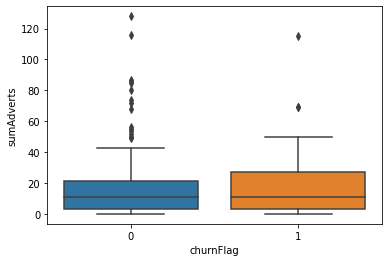

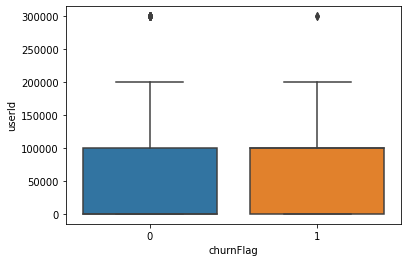

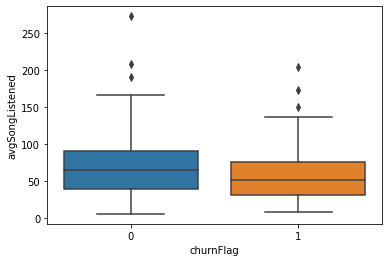

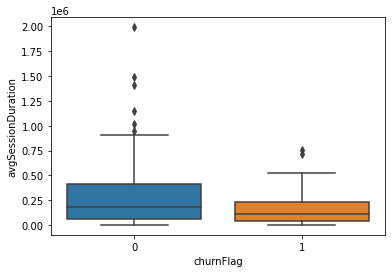

In [31]:
#Creating boxplot for each numeric column
for i in final_df_pandas.columns: 
    
    if (i not in categorial_columns):
        
        fig, ax = plt.subplots();
        sns.boxplot(x="churnFlag", y=i, data=final_df_pandas)

After this analysis we can observe some interesting things:

<ul>
    <li>There are significant differences in the distribution of antiques, users who stay on the platform for a long period of time are more engaged with it.</li>
    <li>The errors in the platform do not have a significant impact on the distinction of the 2 classes, the user without churnflag seems to have more errors than the churn user.</li>
    <li>Advertising seems to have some differences in the distributions that can be useful for our analysis.</li>
    <li>The other numerical features have little difference between the two groups.</li>
</ul>

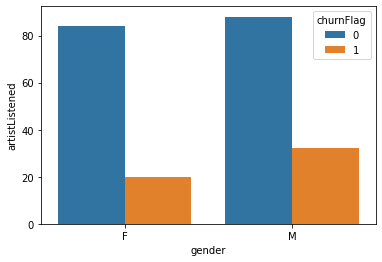

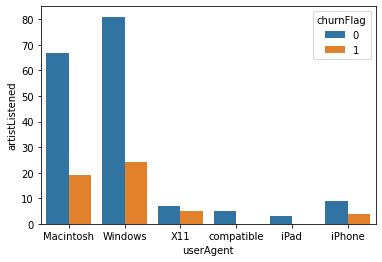

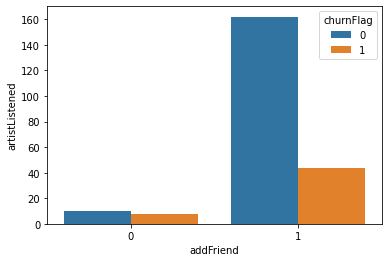

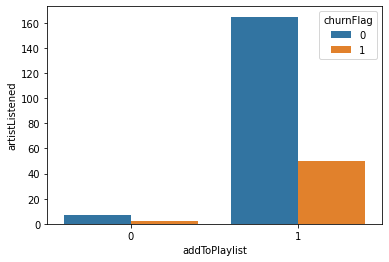

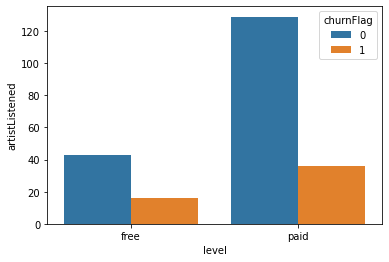

In [32]:
#Creating bar plot for each categorical column
for i in categorial_columns: 
    
    #Avoid ploting the churnFlag column
    if (i != "churnFlag"):
        fig, ax = plt.subplots();
        grouped = final_df_pandas.groupby([i,"churnFlag"], as_index=False).count()
        sns.barplot(x=i, y="artistListened", hue="churnFlag", data=grouped)

After this analysis we can observe some interesting things:

<ul>
    <li>Men seem to churn more than women</li>
    <li>There are some <code>userAgent</code> that cause more churn than others like X11 and iPhone</li>
    <li>Adding friends has an impact on the churn rate of users, as does adding songs to the playlist.</li>
</ul>

In [33]:
num_columns = ['artistListened', 'songsAdded', 'friendsAdded', 'songListened', 'maxItemSession', 'avgItemSession',
       'sessions', 'totalSeconds', 'antique', 'errors', 'churnFlag', 'avgSongListened', 'avgSessionDuration','sumAdverts']

Pair plots are useful tools to extract the behavior of numerical variables such as their distribution and their direct relationship with others through a scatter plot.

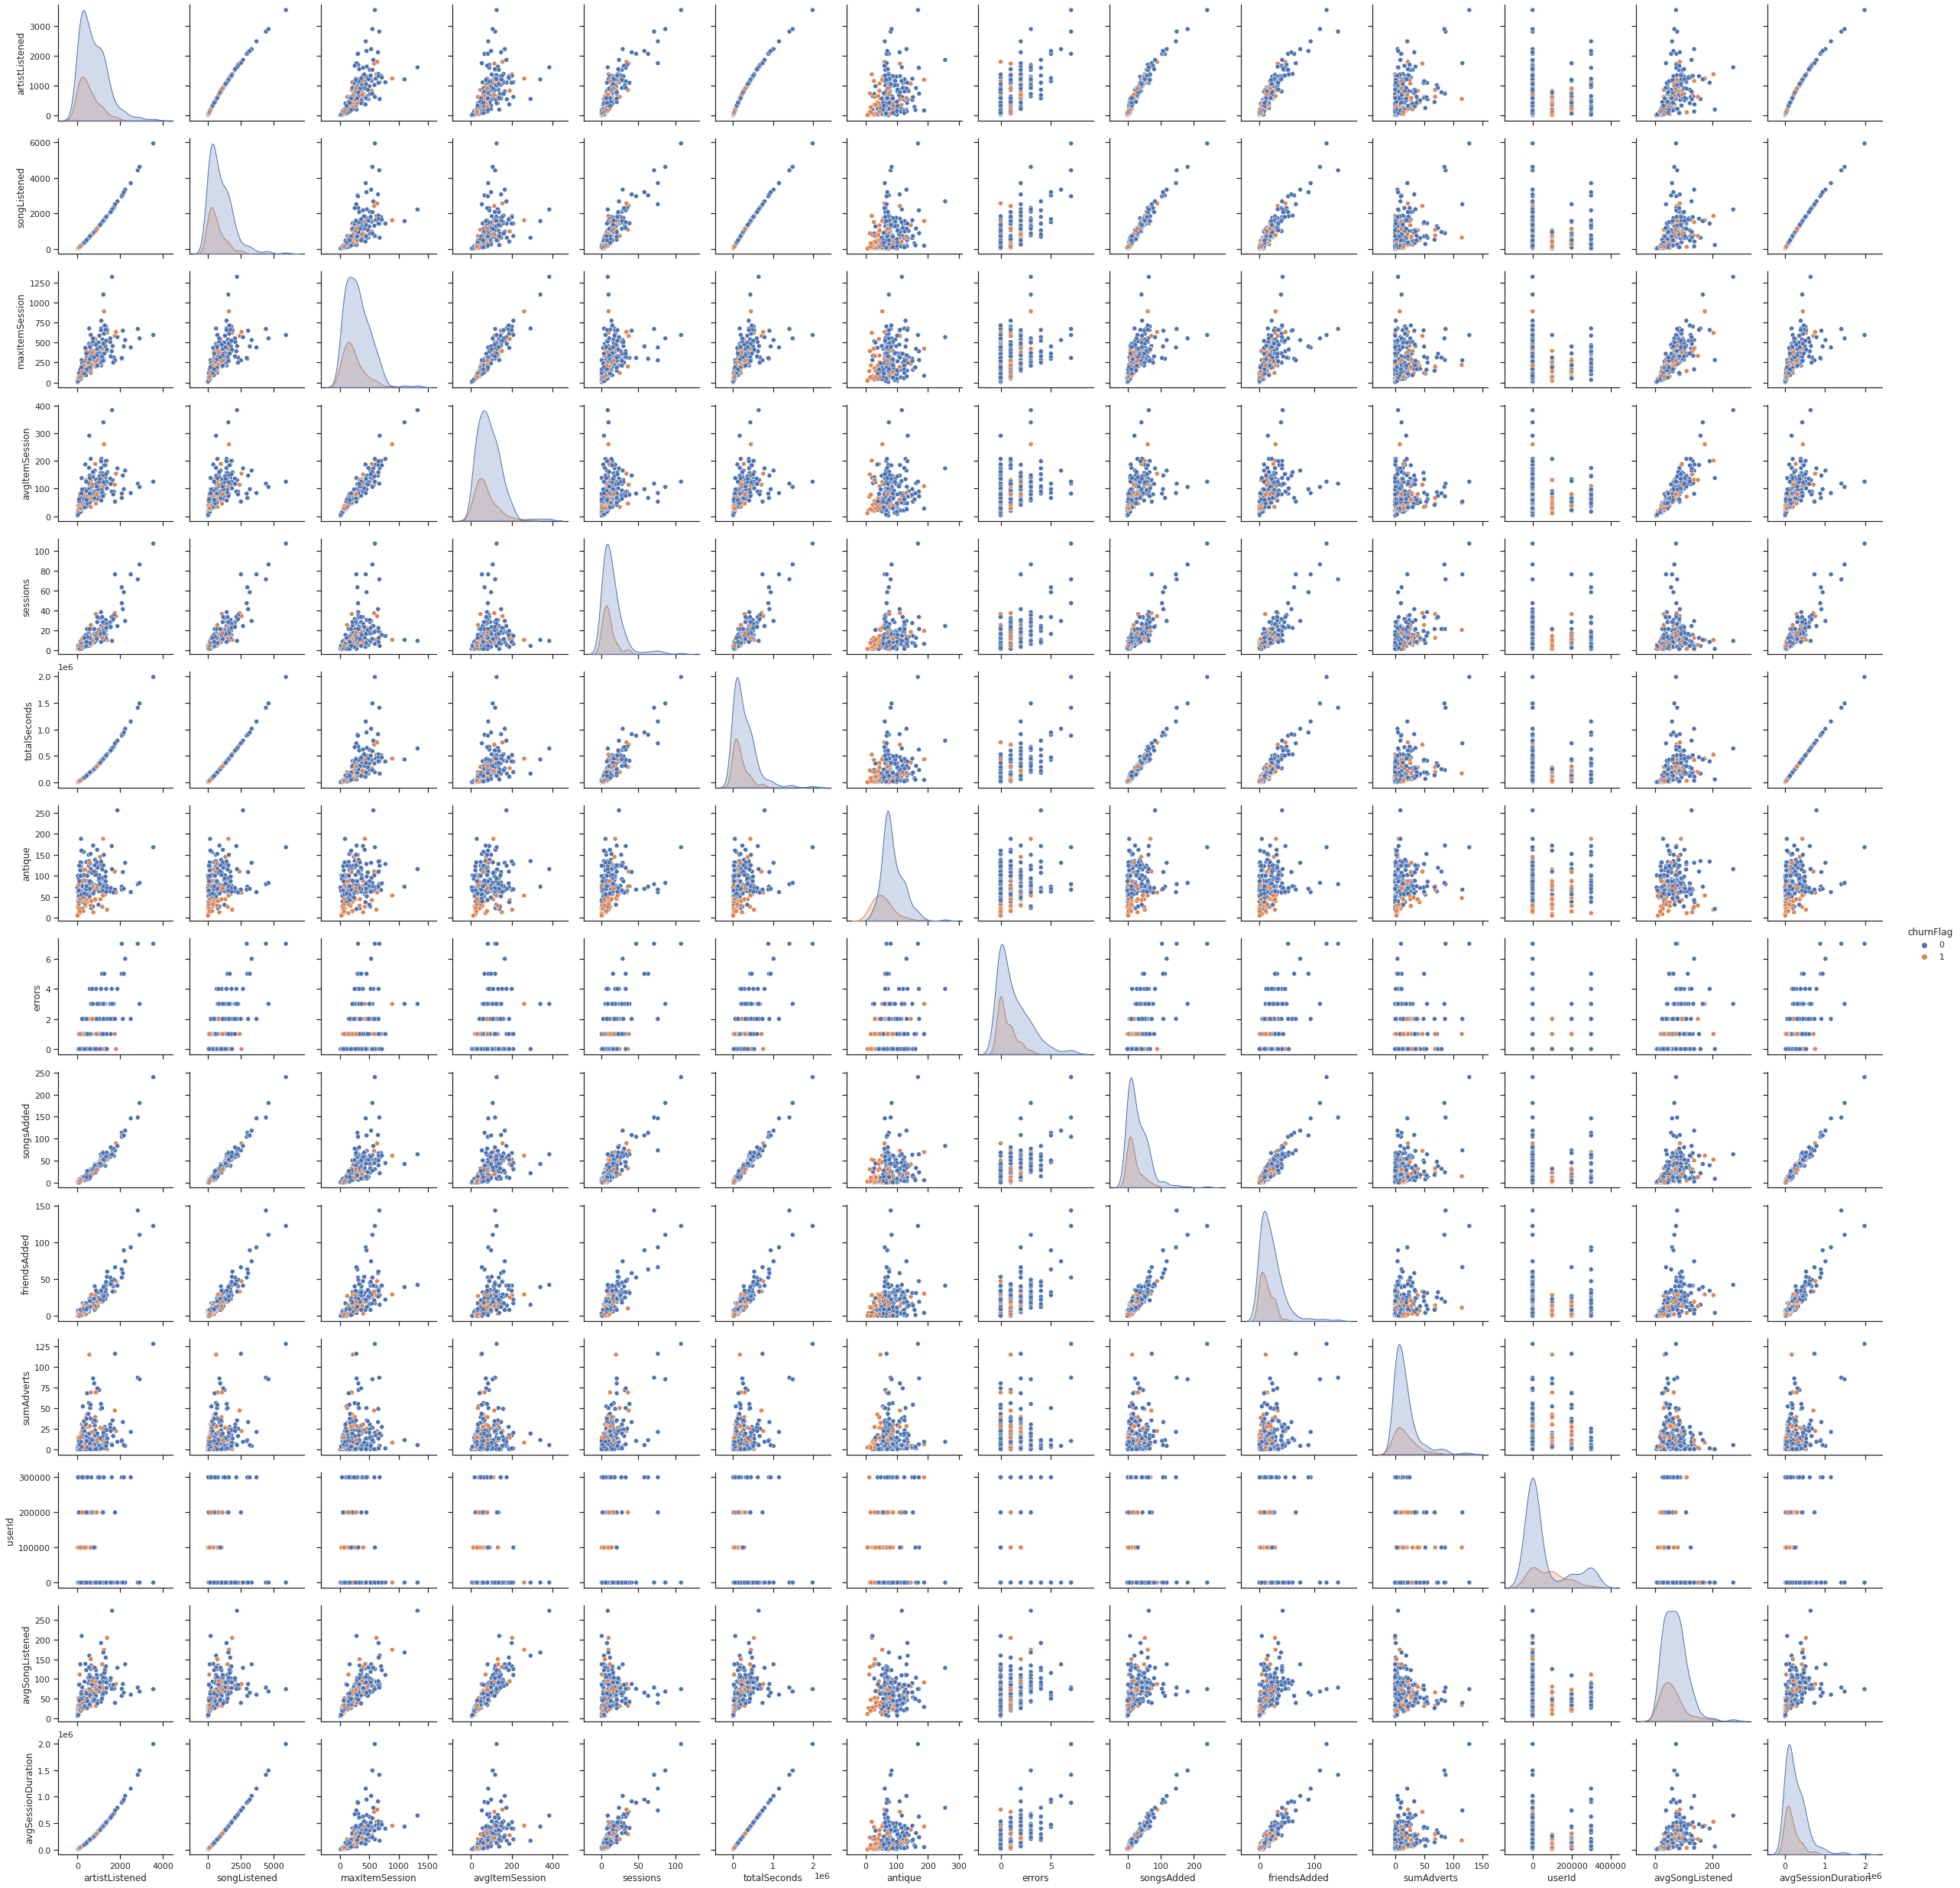

In [34]:
sns.set_theme(style="ticks")
sns.pairplot(final_df_pandas, hue="churnFlag")

With this graph we can see that there are some variables with high correlation and that we can consider them as self-explanatory, so we can eliminate it from the dataframe, in the next step we only take all the numerical columns that visually do not have high correlation and we are going to perform a correlation analysis.

In [35]:
#Select columns to evaluate
num_columns = ['artistListened', 'maxItemSession', 'avgItemSession', 'songsAdded', 'friendsAdded',
       'sessions', 'antique', 'errors', 'churnFlag', 'avgSongListened', 'sumAdverts']

In [36]:
#Correlation analysis
final_df_pandas[num_columns].corr()

,artistListened,maxItemSession,avgItemSession,songsAdded,friendsAdded,sessions,antique,errors,avgSongListened,sumAdverts
artistListened,1.000000,0.711744,0.559970,0.968323,0.928566,0.861664,0.231344,0.705790,0.468690,0.324672
maxItemSession,0.711744,1.000000,0.953449,0.624913,0.616632,0.380938,0.165334,0.450083,0.788417,0.084284
avgItemSession,0.559970,0.953449,1.000000,0.466244,0.450858,0.182823,0.114174,0.361896,0.880620,-0.047908
songsAdded,0.968323,0.624913,0.466244,1.000000,0.929250,0.891161,0.214431,0.680661,0.371957,0.341027
friendsAdded,0.928566,0.616632,0.450858,0.929250,1.000000,0.870612,0.198757,0.666931,0.349895,0.365863
sessions,0.861664,0.380938,0.182823,0.891161,0.870612,1.000000,0.198791,0.599213,0.060234,0.568927
antique,0.231344,0.165334,0.114174,0.214431,0.198757,0.198791,1.000000,0.204584,0.028356,0.101806
errors,0.705790,0.450083,0.361896,0.680661,0.666931,0.599213,0.204584,1.000000,0.341188,0.148023
avgSongListened,0.468690,0.788417,0.880620,0.371957,0.349895,0.060234,0.028356,0.341188,1.000000,-0.191277
sumAdverts,0.324672,0.084284,-0.047908,0.341027,0.365863,0.568927,0.101806,0.148023,-0.191277,1.000000


After this analysis we decide to delete columns: <code>avgItemSession</code>, <code>artistListened</code>, <code>firendsAdded </code>.

In [37]:
#Define the new columns shcema
cols = ['userId', 'gender', 'userAgent', 'maxItemSession', 'sessions', 'antique', 'errors',
               'avgSongListened','songsAdded', 'addFriend', 'addToPlaylist', 'sumAdverts', 'churnFlag']

Finally we establish the final dataframe that will enter to the training model.

In [38]:
#Delete a row that generates conflict to tarnsform antique column to nuemric
#Applysing the final column list
final_df = final_df[cols].filter(final_df.antique != '7:31:46')
#Changing column type for antique
final_df = final_df.withColumn("antique", final_df.antique.cast("int"))

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Features and label definition
First to use any model of the list of pyspark ml models we need to define all our features and labels, this can be made using <code>VectorAssembler</code> and <code>StringIndexer</code>

In [39]:
#Import the nessesary libraries
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [40]:
#Defining categorical varibles list
categoricalColumns = ['gender', 'userAgent', 'addFriend', 'addToPlaylist']
#Defining numeric varibles list
numericCols = ['maxItemSession', 'sessions', 'antique', 'errors', 'avgSongListened','songsAdded', 'sumAdverts']
#Create and empty vactor to store all the step of our pipeline
stages = []

#Apply transformations step to all the categoriacl columns
for categoricalCol in categoricalColumns:
    #Create de StringIndexer
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    #Apply OneHot encoding to all the categoriacl columns
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    #Add the step to stages list
    stages += [stringIndexer, encoder]

#Create the label column using the StringIndexer   
label_stringIdx = StringIndexer(inputCol = 'churnFlag', outputCol = 'label')
#Add the step to the satges list
stages += [label_stringIdx]

#Finally we create the features column using the VectorAssembler transformes
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
#Add the step to the satges list
stages += [assembler]

After creating and defining all the tranformes, we need to spetify a pipeline than can execute all the stages

In [41]:
#Defining pipeline
pipeline = Pipeline(stages = stages)
#Pipeline fit whit the spark dataframe
pipelineModel = pipeline.fit(final_df)
#Apply all the defined transformations
df = pipelineModel.transform(final_df)
#Create the final structure of the dataframe to evaluate the different models
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)

### Train-test split
For this exercise we use a division of 70% for training data and 30% for test data, below is the result of how many rows each partition has. After that, we are going to test two classifiers, Random Forest Classifier and Logistic Regression and see how each performs on our data.

In [42]:
train, test = df.randomSplit([0.7, 0.3], seed = 123456)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 153
Test Dataset Count: 71


### Random Forest Classifier

In [43]:
#Create a basic RandomForestClassifier with default parameters
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
#Fit the model on training data
rfModel = rf.fit(train)
#Create predictions
predictions = rfModel.transform(test)
#Preview predicted data with each class and probability
predictions.select('userId', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+------+-----+--------------------+----------+--------------------+
|userId|label|       rawPrediction|prediction|         probability|
+------+-----+--------------------+----------+--------------------+
|200002|  0.0|[16.3797957904977...|       0.0|[0.81898978952488...|
|   124|  0.0|[15.8097896675477...|       0.0|[0.79048948337738...|
|   154|  0.0|[9.49883559978668...|       1.0|[0.47494177998933...|
|100014|  1.0|[17.1971538741004...|       0.0|[0.85985769370502...|
|    69|  0.0|[18.6697854044726...|       0.0|[0.93348927022363...|
|100021|  1.0|[16.1264264351798...|       0.0|[0.80632132175899...|
|    73|  1.0|[9.94642660577661...|       1.0|[0.49732133028883...|
|    64|  0.0|[13.3067765737736...|       0.0|[0.66533882868868...|
|    30|  0.0|[15.4604240374150...|       0.0|[0.77302120187075...|
|    34|  0.0|[16.3983284993389...|       0.0|[0.81991642496694...|
+------+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [44]:
#Evaluate the model with AUC measure to see how it performs
evaluator = BinaryClassificationEvaluator()
print("Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Area Under ROC: 0.7882205513784464


In [46]:
#Determine the accuracy of the model
print("Accurancy: " + str((predictions.filter(predictions.label == predictions.prediction).count())/(predictions.count())))

Accurancy: 0.8732394366197183


Now we proceed to draw the random forest, for that it is necessary to specify the name of all the characteristics and use the <code>toDebugString</code> function to get all feedback of what the model does.

In [47]:
#Define the features real names
vec= ['genderclassVec', 'userAgentclassVecMacintosh', 'userAgentclassVecWindows', 'userAgentclassVecX11',
 'userAgentclassVeccompatible', 'userAgentclassVeciPad', 'addFriendclassVec', 'addToPlaylistclassVec',
 'maxItemSession', 'sessions', 'antique', 'errors', 'avgSongListened', 'songsAdded', 'sumAdverts']

#Save model debug string
pr = rfModel.toDebugString

#Create a readable structure for the result
for i, feat in enumerate(vec):
    pr = pr.replace('feature ' + str(i) +' ', feat+' ')
    
#Preview the results
print(pr)

RandomForestClassificationModel (uid=RandomForestClassifier_d734e7f10da8) with 20 trees
  Tree 0 (weight 1.0):
    If (userAgentclassVeccompatible in {1.0})
     If (avgSongListened <= 39.5)
      If (sumAdverts <= 0.5)
       Predict: 0.0
      Else (sumAdverts > 0.5)
       If (antique <= 43.0)
        Predict: 0.0
       Else (antique > 43.0)
        Predict: 1.0
     Else (avgSongListened > 39.5)
      If (sessions <= 6.5)
       Predict: 0.0
      Else (sessions > 6.5)
       Predict: 1.0
    Else (userAgentclassVeccompatible not in {1.0})
     If (maxItemSession <= 450.0)
      If (antique <= 34.5)
       If (sessions <= 6.5)
        If (errors <= 0.5)
         Predict: 1.0
        Else (errors > 0.5)
         Predict: 0.0
       Else (sessions > 6.5)
        Predict: 1.0
      Else (antique > 34.5)
       Predict: 0.0
     Else (maxItemSession > 450.0)
      If (sessions <= 29.0)
       Predict: 0.0
      Else (sessions > 29.0)
       If (maxItemSession <= 566.0)
        Predict

Next, we will analyze the important features after training the model and assess whether our first impression of the EDA was close to the final results.

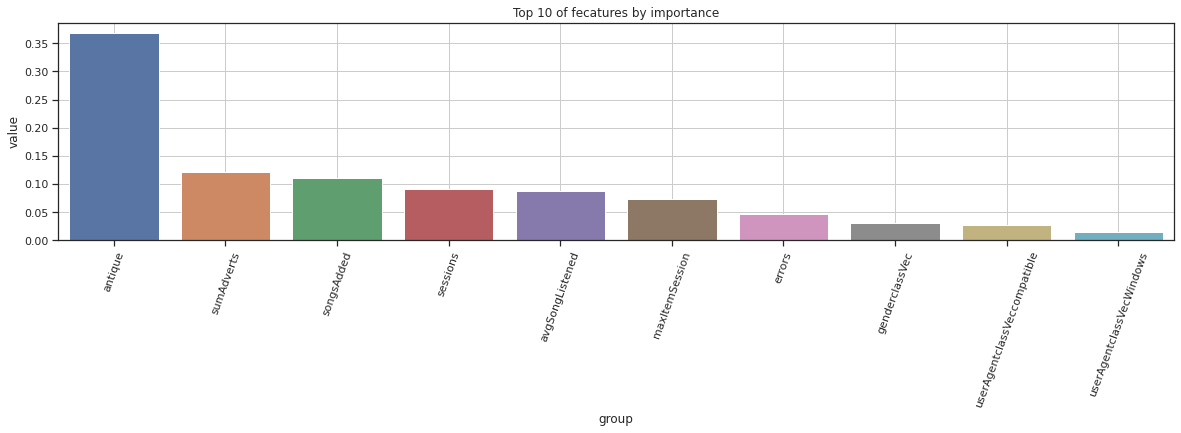

In [48]:
#Defining the group and values list
group = []
value = []

#Add the featureImportances assessment items to the list pair
for i, val in enumerate(rfModel.featureImportances):
    group.append(vec[i])
    value.append(val)

#Transform the data into a dataframe
df_importante = pd.DataFrame({
     'group': group,
     'value': value
    })

#Plot the top 10 variables for the analysis
plt.figure(figsize=(20,4))
plt.xticks(rotation=70)
plt.title('Top 10 of fecatures by importance')
sns.barplot(x="group", y="value", data=df_importante.sort_values(by='value', ascending=False).head(10))
plt.grid()

It seems that our first impression of the data related to the user's age is correct, next we have if the user adds songs to their playlist and the number of items that they listen to in a session.

### Logistic Regression Model

In [49]:
#Create a basic LogisticRegression with default parameters
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
#Fit the model on training data
lrModel = lr.fit(train)
#Create predictions
predictions = lrModel.transform(test)
#Preview predicted data with each class and probability
predictions.select('userId', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+------+-----+--------------------+----------+--------------------+
|userId|label|       rawPrediction|prediction|         probability|
+------+-----+--------------------+----------+--------------------+
|200002|  0.0|[1.08472817888239...|       0.0|[0.74738770402805...|
|   124|  0.0|[5.05787498132752...|       0.0|[0.99368112381906...|
|   154|  0.0|[0.17524917441288...|       0.0|[0.54370050565622...|
|100014|  1.0|[1.26397535209948...|       0.0|[0.77970968336495...|
|    69|  0.0|[2.77545252220563...|       0.0|[0.94133481989405...|
|100021|  1.0|[0.80356264662092...|       0.0|[0.69073604954099...|
|    73|  1.0|[1.31714199397359...|       0.0|[0.78870581580565...|
|    64|  0.0|[0.43853567417775...|       0.0|[0.60791005595617...|
|    30|  0.0|[-0.3745620203428...|       1.0|[0.40743913827546...|
|    34|  0.0|[0.49546542039826...|       0.0|[0.62139309790816...|
+------+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [50]:
#Evaluate the model with AUC measure to see how it performs
evaluator = BinaryClassificationEvaluator()
print('Area Under ROC', evaluator.evaluate(predictions))

Area Under ROC 0.7781954887218044


In [51]:
#Determine the accuracy of the model
print("Accurancy: " + str((predictions.filter(predictions.label == predictions.prediction).count())/(predictions.count())))

Accurancy: 0.8450704225352113


### Grird Search

Grid Search is extremely important to optimize our models and get the best out of each one, for this case we are going to take Rambdom Fores Classifier as a reference, and we will make a grid of parameters with 3 main hyperparameters  <code>maxDepth</code>, <code>numTrees</code> and <code>impurity</code>.

In [88]:
#Creating the base model to test on the grid
rfModel = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
#Include the model into a pipeline
pipeline = Pipeline(stages=[rfModel])

#Structure of a pipe that takes a long time to train
'''
paramGrid = ParamGridBuilder() \
    .addGrid(rfModel.maxDepth,[5, 3, 7]) \
    .addGrid(rfModel.maxBins,[64, 16, 32]) \
    .addGrid(rfModel.numTrees,[50, 10, 20]) \
    .addGrid(rfModel.impurity,['gini', 'entropy']) \
    .build()'''

#Simplified version of the firts grid
paramGrid = ParamGridBuilder() \
    .addGrid(rfModel.maxDepth,[5, 3]) \
    .addGrid(rfModel.numTrees,[10, 20]) \
    .addGrid(rfModel.impurity,['gini', 'entropy']) \
    .build()

#Create the 10-fold cross validator on the pipe using the defined grid
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=10)

In [93]:
#Fit the pipeline on training data
rfModel_grid = crossval.fit(train)
#Execute the predictons
results = rfModel_grid.transform(test)
#Determine the accuracy of the model.
(results.filter(results.label == results.prediction).count())/(results.count())

0.8591549295774648

We see that using the parameter grid we obtain good results but are not as good as default Random Forest, for this case a accurancy of <b>86%</b>. Now we must save the best model and find its hyperparameters

In [95]:
bestModel = rfModel_grid.bestModel
print(rfModel_grid.getEstimatorParamMaps()[np.argmax(rfModel_grid.avgMetrics)])

{Param(parent='RandomForestClassifier_a1962273f636', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 3, Param(parent='RandomForestClassifier_a1962273f636', name='numTrees', doc='Number of trees to train (>= 1).'): 20, Param(parent='RandomForestClassifier_a1962273f636', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini'}


The result shows that the best hyperparametres are:
<ul>
    <li><b>maxDepth:</b> 3</li>
    <li><b>numTrees:</b> 20</li>
    <li><b>impurity:</b> gini</li>
</ul>

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.